<a href="https://colab.research.google.com/github/mot1122/CNN_model/blob/main/use_pytorch/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch_lightning==0.7.1

     |████████████████████████████████| 6.0 MB 12.5 MB/s 
     |████████████████████████████████| 829 kB 37.5 MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_lightning-0.7.1-py3-none-any.whl size=145329 sha256=71126acb572258b9ff2960755b6d67a5ca5000a5a9d346bfd6f75fec7cb0f8f0
  Stored in directory: /root/.cache/pip/wheels/a5/c0/6c/ed64904da20814878f410c520ae61c062c6d7e93bf5c27dcd4
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=2eb16b02e16ec39fe4b763899957668b1185b9c4517d0ad64ad1aa8ce0a85d03
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built pytorch-lightning future
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer

# ベースライン

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
# データの取得と分割
train_val = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# train : val = 0.8 : 0.2
n_train = int(len(train_val) * 0.8)
n_val = len(train_val) - n_train

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# train と val に分割
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


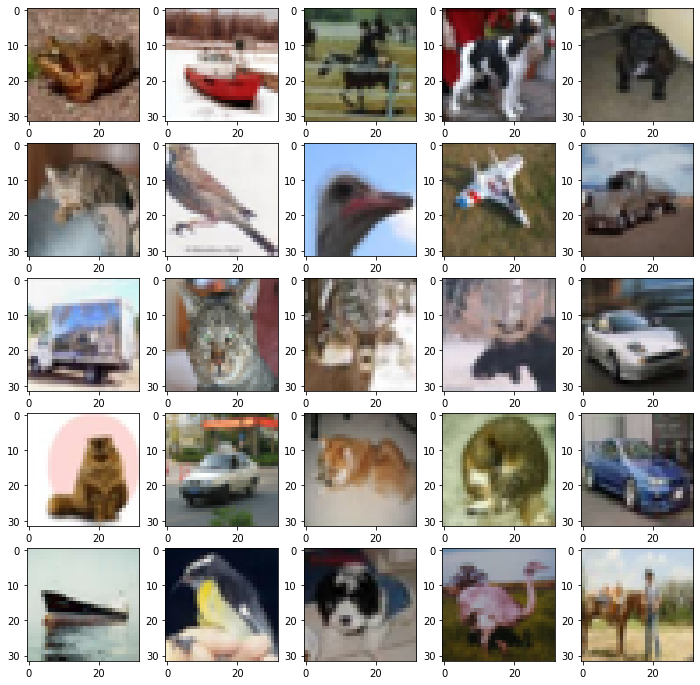

In [5]:
plt.figure(figsize=(12,12))
for i in range(25):
    img = np.transpose(train[i][0].numpy(), (1, 2, 0))
    plt.subplot(5, 5, i+1)
    plt.imshow(img)

In [6]:
class TrainNet(pl.LightningModule):

    def train_dataloader(self):
        return torch.utils.data.DataLoader(train, self.batch_size, shuffle=True)

    def training_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        # 追加
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'loss': loss, 'acc': acc}
        return results

In [7]:
class ValidationNet(pl.LightningModule):

    def val_dataloader(self):
        return torch.utils.data.DataLoader(val, self.batch_size)

    def validation_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'val_loss': loss, 'val_acc': acc}
        return results

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        results =  {'val_loss': avg_loss, 'val_acc': avg_acc}
        return results

In [8]:
class TestNet(pl.LightningModule):

    def test_dataloader(self):
        return torch.utils.data.DataLoader(test, self.batch_size)

    def test_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'test_loss': loss, 'test_acc': acc}
        return results

    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        results = {'test_loss': avg_loss, 'test_acc': avg_acc}
        return results

In [9]:
class Net(TrainNet, ValidationNet, TestNet):

    def __init__(self, batch_size=128):
        super(Net, self).__init__()
        self.batch_size = batch_size
        # 畳み込み層
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        # 全結合層
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def lossfun(self, y, t):
        return F.cross_entropy(y, t)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        # ch: 3 -> 32, size: 32 * 32 -> 16 * 16
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 32 -> 64, size: 16 * 16 -> 8 * 8
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        # ch: 64 -> 128, size: 8 * 8 -> 4 * 4
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
# 乱数のシードを固定
torch.manual_seed(0)

# ネットワーク学習の準備
net = Net(batch_size=1024)
trainer = Trainer(gpus=1, max_epochs=10, early_stop_callback=False)
      
trainer.fit(net)

trainer.test()
trainer.callback_metrics

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'acc': 0.546875,
 'epoch': 9,
 'loss': 1.3797059059143066,
 'test_acc': 0.5733039975166321,
 'test_loss': 1.2057403326034546,
 'val_acc': 0.5688934922218323,
 'val_loss': 1.2212928533554077}

In [12]:
img = train[100][0]
ToPIL = transforms.ToPILImage()
img = ToPIL(img)

In [13]:
# 各処理の変換前後を表示
def show(in_img, out_img):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('before')
    plt.imshow(in_img)
    
    plt.subplot(1, 2, 2)
    plt.title('after')
    plt.imshow(out_img)

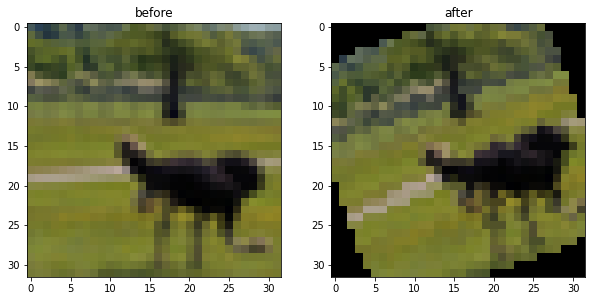

In [14]:
transform = transforms.RandomRotation(degrees=30) #degreesは角度
out = transform(img)

show(img, out)

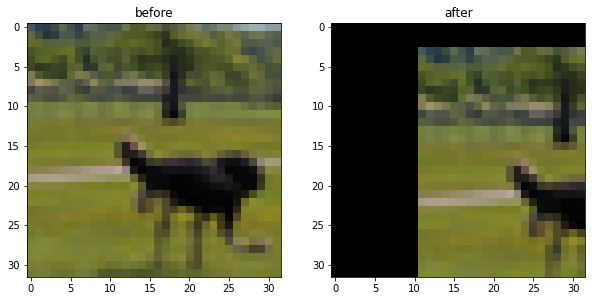

In [15]:
transform = transforms.RandomAffine(degrees=0, translate=(0.5, 0.5)) #-0.5~0.5の間でランダムに水平移動
out = transform(img)

show(img, out)

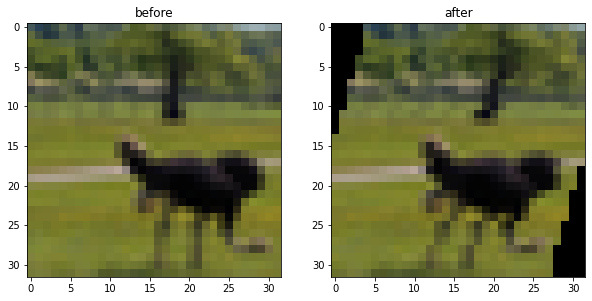

In [16]:
transform = transforms.RandomAffine(degrees=0, translate=(0, 0), shear=(0, 30)) #平行四辺形に変形
out = transform(img)

show(img, out)

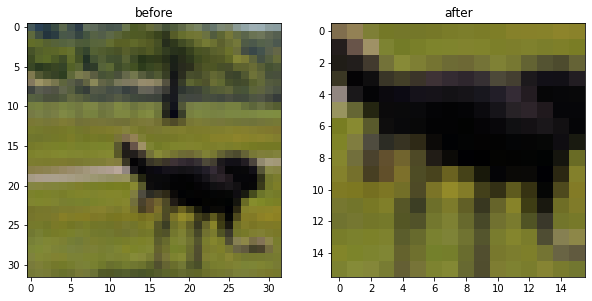

In [17]:
transform = transforms.RandomCrop((16, 16))
out = transform(img)

show(img, out)

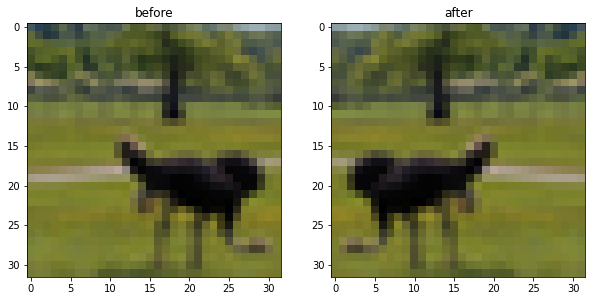

In [18]:
transform = transforms.RandomHorizontalFlip(p=1)  #pは反転させる確率
out = transform(img)

show(img, out)

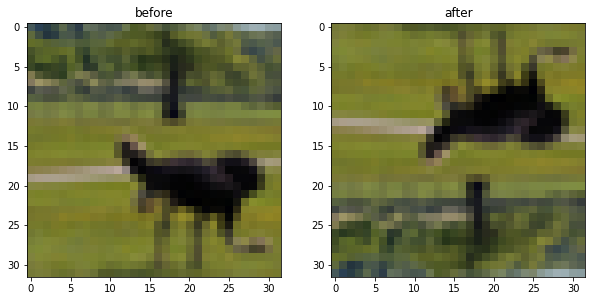

In [19]:
transform = transforms.RandomVerticalFlip(p=1) 
out = transform(img)

show(img, out)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1376: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


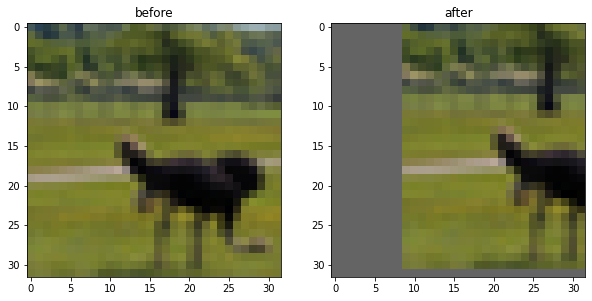

In [20]:
#水平移動し、空白はグレーで埋める
transform = transforms.RandomAffine(degrees=0, translate=(0.5, 0.5), fillcolor=(100, 100, 100))
out = transform(img)

show(img, out)

In [21]:
# RandomCrop 処理をかける
transform = transforms.RandomCrop((16, 16))
out = transform(img)

# 画像の保存
out.save('out.jpg')

In [22]:
# augmentationするかはランダムに選ばれる

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [23]:
train_val = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# train : val = 0.8 : 0.2
n_train = int(len(train_val) * 0.8)
n_val = len(train_val) - n_train

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)

# train と val に分割
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
torch.manual_seed(0)

# ネットワーク学習の準備
net = Net(batch_size=1024)
trainer = Trainer(gpus=1, max_epochs=10, early_stop_callback=False)

trainer.fit(net)

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

Validating:   0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
trainer.test()
trainer.callback_metrics

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'acc': 0.453125,
 'epoch': 9,
 'loss': 1.293131947517395,
 'test_acc': 0.5186064839363098,
 'test_loss': 1.384827971458435,
 'val_acc': 0.5197385549545288,
 'val_loss': 1.3870205879211426}